In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

https://github.com/ilia-stepanov/ML-Stepik/blob/master/ML_Stepik1.ipynb

**events_train.csv** - данные о действиях, которые совершают студенты со стэпами

| Признак  | Описание |
| --- | --- |
| step_id       | id стэпа |
| user_id       | анонимизированный id юзера |
| timestamp     | время наступления события в формате unix date |
| action        | событие, возможные значения: |
|               | - *discovered*      пользователь перешел на стэп             |
|               | - *viewed*          просмотр шага                            |
|               | - *started_attempt*  начало попытки решить шаг, ранее нужно <br> было явно нажать на кнопку - начать решение, перед тем как <br> приступить к решению практического шага |
|               | - *passed*          удачное решение практического шага |



**submissions_train.csv** - данные о времени и статусах сабмитов к практическим заданиям
|Признак            | Описание                                   |
|-------------------|--------------------------------------------|
|step_id            | id стэпа|
|timestamp          | время отправки решения в формате unix date|
|submission_status  | статус решения|
|user_id            | анонимизированный id юзера|

In [7]:
events_data = pd.read_csv('data/event_data_train.zip', sep=',') 
# или  events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
display(events_data.head())
display(events_data.shape)

submissions_data = pd.read_csv('submissions_data_train.zip', sep=',')
display(submissions_data.head())
display(events_data.shape)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


(3480703, 4)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


(3480703, 4)

Это сырые данные, которые представляют собой логи событий. Их нужно разметить и обработать.

In [8]:
# уникальные значения признака 'action'
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

'viewed' - посмотреть, 'passed' - решить, 'discovered' - впервые увидеть, 'started_attempt' - начать решать

Данные признака  **Timestamp ** - представлены в особом формате времени в целых секундах с 1970 года. 

In [13]:
events_data['date']=pd.to_datetime(events_data.timestamp, unit='s')
display(events_data.head())
print(f"Период дат просмотра курса: \nначало {events_data['date'].min()} \nконец {events_data['date'].max()}")

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


Период дат просмотра курса: 
начало 2015-06-15 04:00:48 
конец 2018-05-19 23:33:31


Однако, дату целесообразно представить в Pandas"овском формате datetime. Создадим новый признак 'date' и э

In [16]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Сколько уникальных пользователей записалось на курс и в какой день

In [21]:
events_data.groupby('day')['user_id'].nunique().head()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

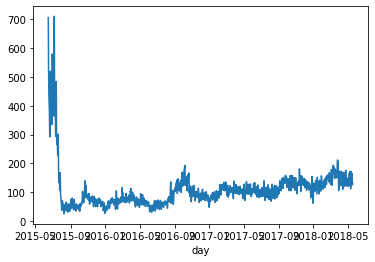

In [35]:
fig_1 = px.line(
    data_frame=events_data.groupby('day').nunique(), 
    y='user_id',
    #orientation='h'
    #opacity=0.5, # непрозрачность 
    #marginal='box'
    )
fig_1.update_layout(width=600, height=400)
fig_1.show();


events_data.groupby('day').user_id.nunique().plot();

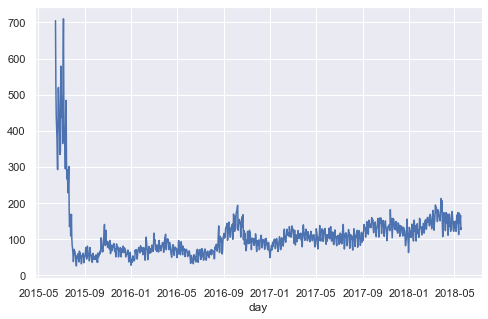

In [39]:
# Надстройка для изменения размера графика
sns.set(rc={'figure.figsize': (8,5)})
events_data.groupby('day').user_id.nunique().plot();

Найдём распределение баллов, которые получали позьзователи в проце курса. 
Помним, что passed - завершение практического шага на курсе.

<AxesSubplot:>

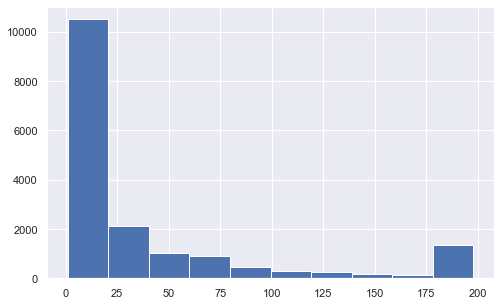

In [81]:
incomplete_events_data = events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index = False).agg({'step_id': 'count'}) \
    .rename(columns = {'step_id': 'passed_step'}).passed_step

display(incomplete_events_data.hist());


fig_2 = px.histogram(
    data_frame=incomplete_events_data, 
    x='passed_step',
    nbins=10,
    opacity=0.5, # непрозрачность 
    marginal='box'
)
fig_2.update_layout(
    title=dict(text='Рис.2 - Количество завершенных степов <br> при плохой группировке', x=.5, xanchor='center'),
    width=600, height=400,
    xaxis_title_text = 'Перерыв, мес.',
    yaxis_title_text = 'Соискатели, чел.',
    template="simple_white"
)
fig_2.show();

Однако, при этом мы :
а) Потеряем данные о тех юзерах, у которых нет иных событий кроме как passed
б) Синтаксическая ошибка в коде, просто ничего не будет работать
в) Пользователи, у которых нет ни одного passed стэпа вообще не попадут в результат

Ответ в) Мы потеряли часть пользователей, которые не прошли ни одного степа. Утчтём же их

In [46]:
result = events_data[events_data.action == 'passed'].groupby('user_id', as_index = False)\
    .agg({'step_id': 'count'}).rename(columns = {'step_id': 'passed_step'}).passed_step.min()
print(f" Количество пользователей, которые ушли после первого степа: {result}")

 Количество пользователей, которые ушли после первого степа: 1


Воспользуемся таблицей, в которой посчитаем количество пользователей, прошедших степы

In [87]:
# включаем 0 в выборку
complete_events_data = events_data.pivot_table(
    index='user_id', 
    columns='action', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0 #установим значение 0 для тех пользователей, у кого нет завершенного степа
).reset_index()

display(complete_events_data.head())

# или так
display(complete_events_data.sort_values(by='passed').head()) #['passed'].value_counts(ascending=False)


action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
11933,16572,1,0,0,1
2752,3774,1,0,0,1
11928,16563,1,0,1,1
2755,3778,1,0,0,1


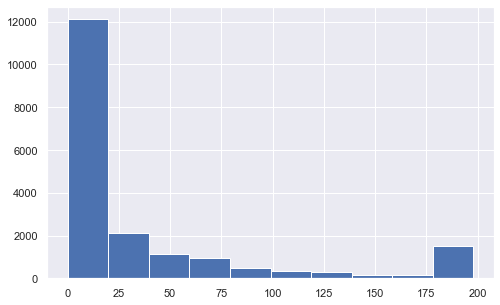

In [66]:
# построим график по более свежим данным
fig_3 = px.histogram(
    data_frame=complete_events_data, 
    x='passed',
    nbins=10,
    opacity=0.5, # непрозрачность 
    marginal='box'
)
fig_3.update_layout(
    title=dict(text='Рис.3 - Количество завершенных степов', x=.5, xanchor='center'),
    width=600, height=400,
    template="simple_white"
)
fig_3.show();

events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().discovered.hist();

Как можно заметить, количество наблюдений в первой группе выросло с 10381 до 12353